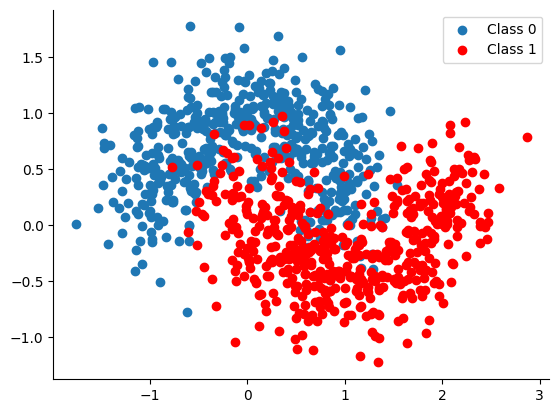

In [1]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt 
import seaborn as sns

X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
sns.despine()
plt.legend();

In [2]:
import mxnet as mx
from mxnet import nd, autograd, gluon,np

n_groups = 18

n_grps_sq = int(np.sqrt(n_groups))
n_samples = 100

In [3]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

In [4]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.0
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(np.asarray(Y))

[17:41:28] ../src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


In [30]:
np.stack(Ys,axis=0).shape

(18, 100)

In [31]:
Xs = np.stack(Xs,axis=0)
Ys = np.stack(Ys,axis=0)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

In [32]:
Ys_train[0,:]

array([0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])

In [36]:
import sys
sys.path.append("../") 
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model_ctx=mx.gpu()
hyper={'alpha':1.0}

class NN(softmax):

    def __init__(self,_hyper,in_units,out_units,ctx=mx.cpu()):
        self.hyper=_hyper
        self.ctx=ctx
        self.net  = self._init_net(in_units,out_units)
        
    def _init_net(self,in_units,out_units):
        net = gluon.nn.Sequential()#inicializacion api sequencial
        net.add(gluon.nn.Dense(5,in_units=in_units))
        net.add(gluon.nn.Dense(5))
        net.add(gluon.nn.Dense(out_units))#capa de salida
        self.reset(net)
        return net

    def forward(self,par, **args):
        for k,v in args.items():
            if k=='X_train':
                X=v
        y_linear = self.net.forward(X)
        yhat = npx.sigmoid(y_linear)
        y_hat=mxp.bernoulli.Bernoulli(prob=y_hat)
        return y_hat
    
    def negative_log_prior(self, par,**args):
        for k,v in args.items():
            if k=='X_train':
                X=v
        param_prior=mxp.normal.Normal(loc=0.,scale=np.sqrt(self.hyper['alpha']))
        log_prior=list()
        for var in par.keys():
            for p in par[var].list_data():
                if p.ctx==X.ctx:
                    log_prior.append(np.sum(param_prior.log_prob(p)))
        return -np.sum(np.stack(log_prior))
    
    def negative_log_likelihood(self,par,**args):
        for k,v in args.items():
            if k=='X_train':
                X=v
            elif k=='y_train':
                y=v
        y_hat = self.forward(par,X_train=X)
        return -np.sum(y_hat.log_prob(y))
        
    def loss(self,par,**args):
        log_like=self.negative_log_likelihood(par,**args)
        log_prior=self.negative_log_prior(par,**args)
        return log_like+log_prior


In [ ]:
model=NN(hyper,in_units=2,out_units=1,ctx=model_ctx)

[17:40:41] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8202 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.
